In [2]:
factors = ["DEP", "ED", "PI", "MHP", "GDP", "NOI"]

## Scaling

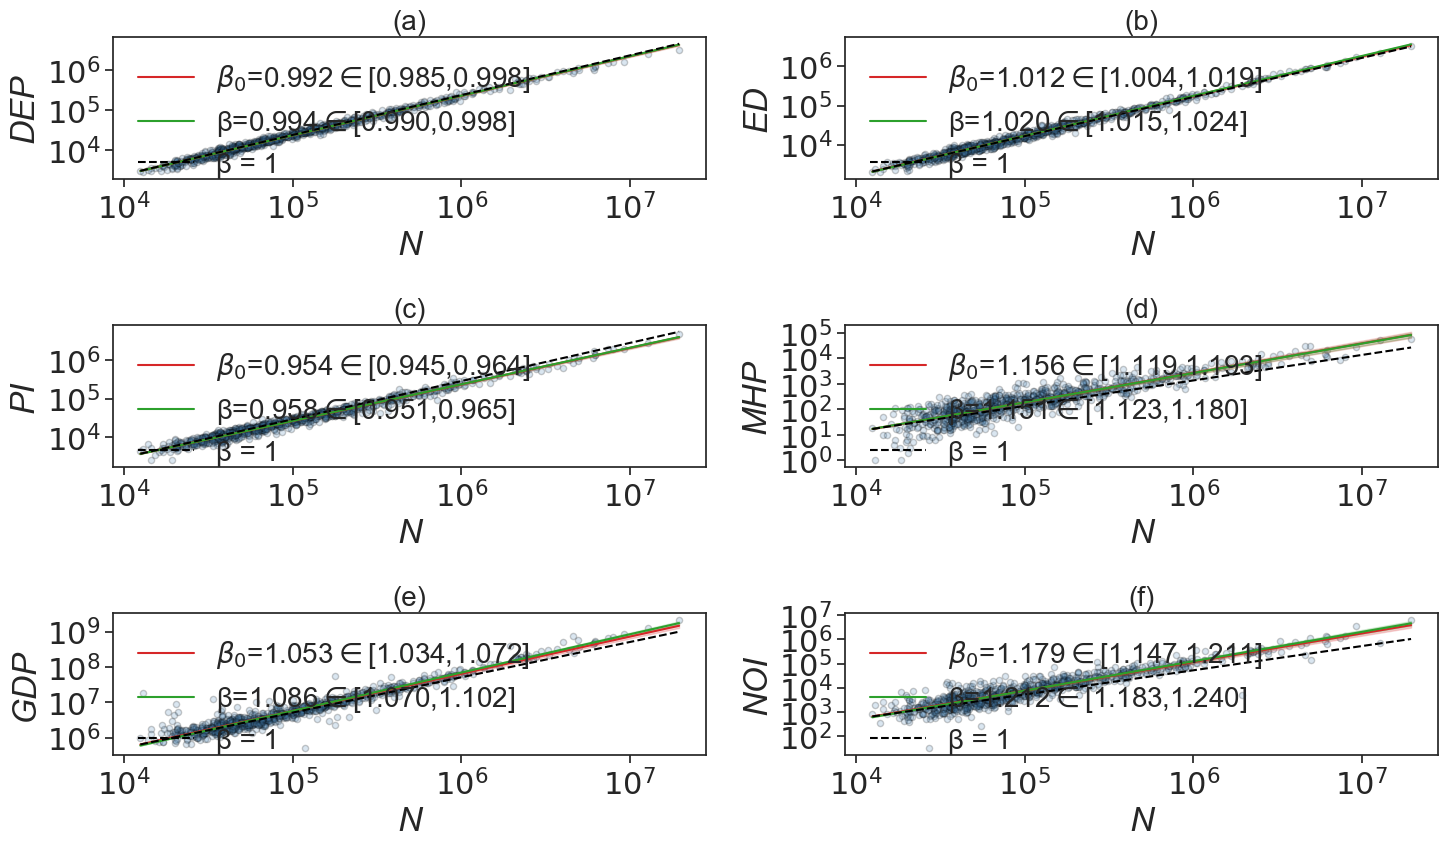

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator, FuncFormatter
plt.rc("font", family="Arial")

# ------------ config ------------
m1_path = '../00_data/14_output/SAMIs_pop.csv'          
m2_path = '../00_data/14_output/FsAMIs_0903_pop_ko.csv'
m1_name = 'SAMI'
m2_name = 'FsAMI'


# ------------ helpers ------------
def harmonize_factor_names(df):
    df = df.copy()
    df.loc[df['factor'] == 'gdp', 'factor'] = 'GDP'
    df.loc[df['factor'] == 'mental_health_providers', 'factor'] = 'MHP'
    df.loc[df['factor'] == 'DEPRESSION', 'factor'] = 'DEP'
    df.loc[df['factor'] == 'noise50n', 'factor'] = 'NOI'
    df.loc[df['factor'] == 'BINGE', 'factor'] = 'ED'
    df.loc[df['factor'] == 'FFR20', 'factor'] = 'FFR'
    df.loc[df['factor'] == 'LPA', 'factor'] = 'PI'
    return df

def prep_model_df(path, factors, drop_cols):
    df = pd.read_csv(path)
    df = harmonize_factor_names(df)
    df = df.loc[df['factor'].isin(factors)].drop(columns=drop_cols, errors='ignore')
    df = (df.groupby('factor', as_index=False)
            .mean(numeric_only=True))
    return df.set_index('factor')

def compute_intercepts(dfm, x_all, y_logs, factors):

    dfm = dfm.copy()
    dfm['beta'] = pd.to_numeric(dfm['beta'], errors='raise')
    intercepts = {}
    for f in factors:
        y = y_logs[f]
        mask = np.isfinite(x_all) & np.isfinite(y)
        x_f = x_all[mask]
        y_f = y[mask]
        b   = float(dfm.at[f, 'beta'])
        a   = (y_f - b * x_f).mean()
        intercepts[f] = float(a)
    dfm['intercept'] = pd.Series(intercepts)
    return dfm

# ------------ data: raw scatter base ------------
df_raw = pd.read_csv("../00_data/13_final/cbsa_level.csv")
df_raw = df_raw.rename(columns={
    'gdp': 'GDP',
    'mental_health_providers': 'MHP',
    'DEPRESSION': 'DEP',
    'noise50n': 'NOI',
    'BINGE': 'ED',
    'FFR20': 'FFR',
    'LPA': 'PI'
})
data = df_raw[factors + ['cbsacode','TotalPopulation']].dropna()

# log10-safe
data_ = data[["TotalPopulation"] + factors].copy()
for c in ["TotalPopulation"] + factors:
    data_.loc[data_[c] <= 0, c] = np.nan

x_all = np.log10(data_["TotalPopulation"]).values
y_logs = {f: np.log10(data_[f]).values for f in factors}

# ------------ model tables ------------
dfm1 = prep_model_df(m1_path, factors, drop_cols=['SAMI','cbsacode','Unnamed: 0'])
dfm2 = prep_model_df(m2_path, factors, drop_cols=['FsAMI','cbsacode'])

# intercept
dfm1 = compute_intercepts(dfm1, x_all, y_logs, factors)
dfm2 = compute_intercepts(dfm2, x_all, y_logs, factors)

# ------------ plot 2×3 with two models overlaid ------------
pow10fmt = FuncFormatter(lambda k, pos: rf"$10^{{{int(np.round(k))}}}$")
sns.set_theme(style="ticks", font_scale=2)
fig, axes = plt.subplots(3, 2, figsize=(15, 9))
panel_labels = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)"]

for ax, f, lbl in zip(axes.flat, factors, panel_labels):
    y = y_logs[f]
    mask = np.isfinite(x_all) & np.isfinite(y)
    x_f = x_all[mask]
    y_f = y[mask]

    # scatter once
    ax.scatter(x_f, y_f, s=20, alpha=0.2, edgecolor="black", color="steelblue")

    # starting poing
    x0 = x_f.min()

    # ---- SAMI ----
    b1  = float(dfm1.at[f, "beta"])
    a1  = float(dfm1.at[f, "intercept"])
    lo1 = float(dfm1.at[f, "CI_lower"]) if "CI_lower" in dfm1.columns else b1
    hi1 = float(dfm1.at[f, "CI_upper"]) if "CI_upper" in dfm1.columns else b1
    y01 = a1 + b1 * x0
    xx  = np.linspace(x_f.min(), x_f.max(), 200)

    ax.plot(xx, y01 + b1 * (xx - x0), lw=1.5, color="#D62728", label=f"$β_0$={b1:.3f}$\in$[{lo1:.3f},{hi1:.3f}]")
    if "CI_lower" in dfm1.columns and "CI_upper" in dfm1.columns:
        ax.fill_between(xx, y01 + lo1 * (xx - x0), y01 + hi1 * (xx - x0), alpha=0.20, color="#D62728")

    # ---- FsAMI ----
    b2  = float(dfm2.at[f, "beta"])
    a2  = float(dfm2.at[f, "intercept"])
    lo2 = float(dfm2.at[f, "CI_lower"]) if "CI_lower" in dfm2.columns else b2
    hi2 = float(dfm2.at[f, "CI_upper"]) if "CI_upper" in dfm2.columns else b2
    y02 = a2 + b2 * x0

    ax.plot(xx, y02 + b2 * (xx - x0), lw=1.5, ls='-', color="#2CA02C", label=f"β={b2:.3f}$\in$[{lo2:.3f},{hi2:.3f}]")
    if "CI_lower" in dfm2.columns and "CI_upper" in dfm2.columns:
        ax.fill_between(xx, y02 + lo2 * (xx - x0), y02 + hi2 * (xx - x0), alpha=0.20, color="#2CA02C")

    # β=1
    ax.plot(xx, y01 + 1.0 * (xx - x0), color="black", lw=1.5, ls="--", label="β = 1")

    # 10^k
    ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=6))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=6))
    ax.xaxis.set_major_formatter(pow10fmt)
    ax.yaxis.set_major_formatter(pow10fmt)

    ax.set_xlabel("N", fontstyle="italic")
    ax.set_ylabel(f, fontstyle="italic")
    ax.set_title(f"{lbl}", fontsize=20)
    ax.legend(loc="upper left", frameon=False, fontsize=20)

plt.tight_layout()
plt.show()

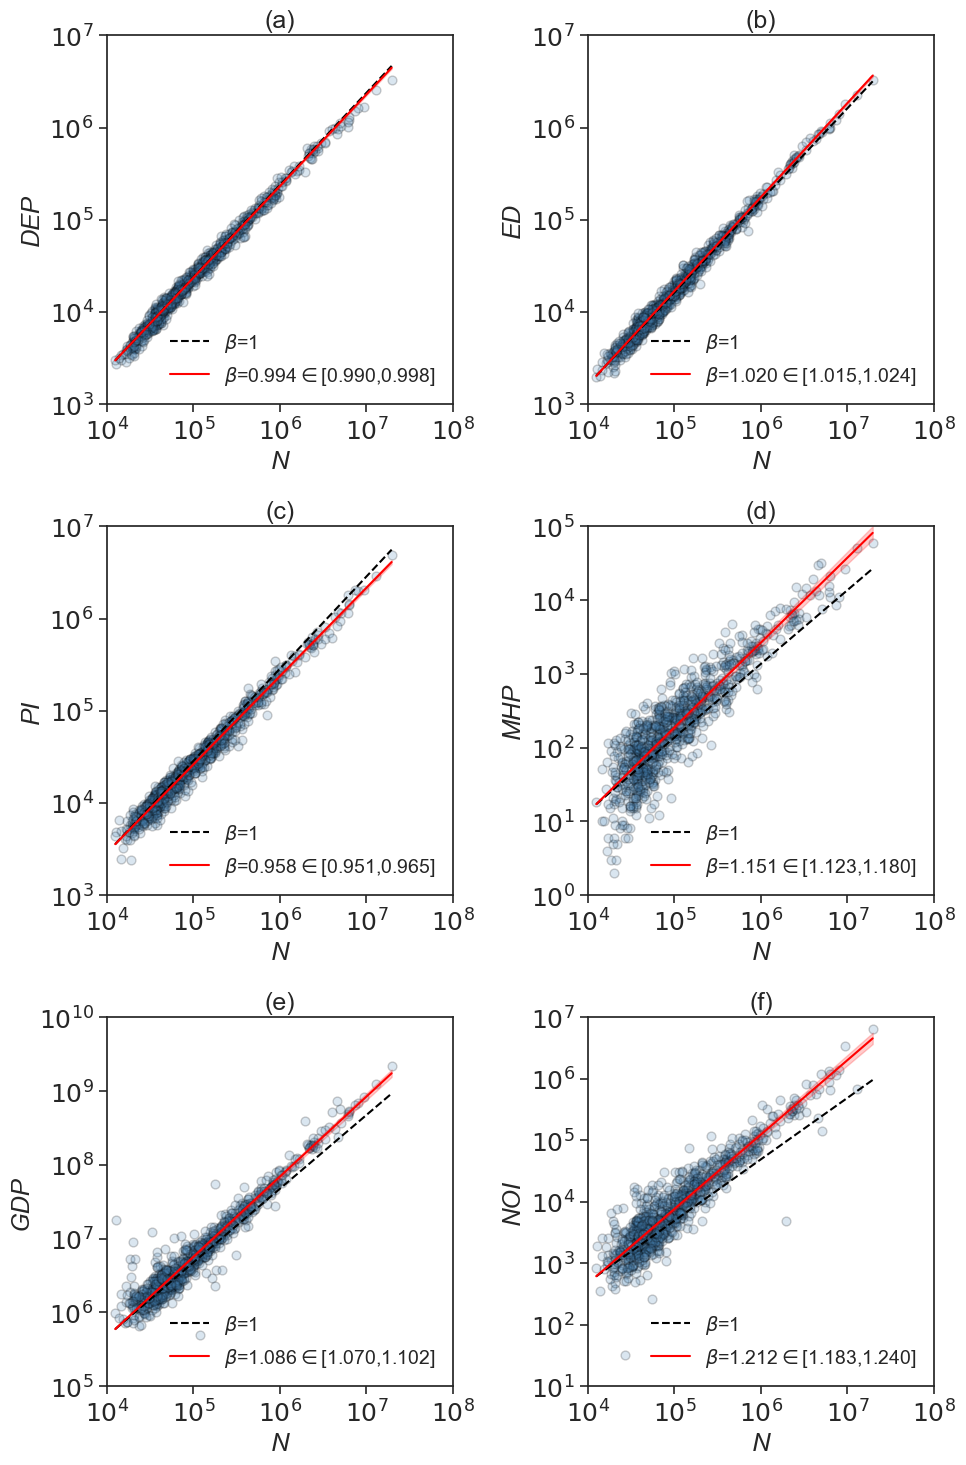

In [16]:
import numpy as np
import pandas as pd  # <-- make sure this is imported
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import LogLocator, FuncFormatter
from matplotlib.ticker import MultipleLocator

plt.rc("font", family="Arial")

df = pd.read_csv('../00_data/14_output/FsAMIs_0903_pop_ko.csv')

df.loc[df['factor'] == 'gdp', 'factor'] = 'GDP'
df.loc[df['factor'] == 'mental_health_providers', 'factor'] = 'MHP'
df.loc[df['factor'] == 'DEPRESSION', 'factor'] = 'DEP'
df.loc[df['factor'] == 'noise50n', 'factor'] = 'NOI'
df.loc[df['factor'] == 'BINGE', 'factor'] = 'ED'
df.loc[df['factor'] == 'FFR20', 'factor'] = 'FFR'
df.loc[df['factor'] == 'LPA', 'factor'] = 'PI'

df_models = df.loc[df['factor'].isin(factors)].drop(columns=['FsAMI','cbsacode']).drop_duplicates().reset_index(drop=True)

df_raw = pd.read_csv("../00_data/13_final/cbsa_level.csv")
df_raw = df_raw.rename(columns={
    'gdp': 'GDP',
    'mental_health_providers': 'MHP',
    'DEPRESSION': 'DEP',
    'noise50n': 'NOI',
    'BINGE': 'ED',
    'FFR20': 'FFR',
    'LPA': 'PI'
})
data = df_raw[factors +['cbsacode','TotalPopulation']].dropna()

# log10-safe copy
data_ = data[["TotalPopulation"] + factors].copy()
for c in ["TotalPopulation"] + factors:
    data_.loc[data_[c] <= 0, c] = np.nan

x_all = np.log10(data_["TotalPopulation"]).values
y_logs = {f: np.log10(data_[f]).values for f in factors}

# ---- compute intercepts with aligned masks; read beta as a scalar
dfm = df_models.set_index("factor").copy()   # <-- factor is now the index
intercepts = {}
for f in factors:
    y = y_logs[f]
    mask = np.isfinite(x_all) & np.isfinite(y)
    x_f = x_all[mask]
    y_f = y[mask]
    b   = float(dfm.at[f, "beta"])
    a   = (y_f - b * x_f).mean()             # α = mean(y - βx) on aligned rows
    intercepts[f] = float(a)

# write intercepts back by factor (no misalignment)
dfm["intercept"] = pd.Series(intercepts)

# ---- plotting
pow10fmt = FuncFormatter(lambda k, pos: rf"$10^{{{int(np.round(k))}}}$")
sns.set_theme(style="ticks",font_scale=1.5)
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

def snap_decade(val, up=True):
    """Round value to nearest power of 10"""
    exp = np.floor(np.log10(val)) if not up else np.ceil(np.log10(val))
    return 10**exp

panel_labels = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)"]

pad = 0.05

for ax, f, lbl in zip(axes.flat, factors, panel_labels):
    y = y_logs[f]
    mask = np.isfinite(x_all) & np.isfinite(y) & (x_all > 0) & (y > 0)
    x_f = x_all[mask]
    y_f = y[mask]

    # scatter
    ax.scatter(x_f, y_f, s=40, alpha=0.2, edgecolor="black", color="steelblue")

    # model params
    b  = float(dfm.at[f, "beta"])
    lo = float(dfm.at[f, "CI_lower"])
    hi = float(dfm.at[f, "CI_upper"])
    a  = float(dfm.at[f, "intercept"])

    # anchor at minimum observed population
    y0 = y_f.min()
    x0 = x_f.min()
    y0 = a + b * x0           # model-predicted y at x0 (stable anchor)
    xx = np.linspace(x_f.min(), x_f.max(), 200)

    # β = 1 baseline sharing the SAME anchor point (x0, y0)
    ax.plot(xx, y0 + 1.0 * (xx - x0), color="black", lw=1.5, ls="--", label="$β$=1")

    # fitted line anchored at (x0, y0)
    ax.plot(xx, y0 + b * (xx - x0), color="red", lw=1.5, label=f"$β$={b:.3f}$\in$[{lo:.3f},{hi:.3f}]")
    # CI band anchored the same way using slope CI bounds
    ax.fill_between(xx,
                    y0 + lo * (xx - x0),
                    y0 + hi * (xx - x0),
                    color="red", alpha=0.20)

    # inside your loop after plotting:
    xk_min = np.floor(x_f.min());  xk_max = np.ceil(x_f.max())
    yk_min = np.floor(y_f.min());  yk_max = np.ceil(y_f.max())

    ax.set_xlim(xk_min, xk_max)     # edges at integer exponents
    ax.set_ylim(yk_min, yk_max)

    ax.xaxis.set_major_locator(MultipleLocator(1.0))  # ticks every decade
    ax.yaxis.set_major_locator(MultipleLocator(1.0))
    ax.xaxis.set_major_formatter(pow10fmt)
    ax.yaxis.set_major_formatter(pow10fmt)
    ax.minorticks_off()

    ax.tick_params(axis="both", which="major", labelsize=18, width=1.2, length=6)

    ax.set_xlabel("N", fontstyle="italic", fontsize=18)
    ax.set_ylabel(f, fontstyle="italic", fontsize=18)
    ax.set_title(f"{lbl}", fontsize=18) 
    ax.legend(loc="lower right", frameon=False, fontsize=14)

plt.tight_layout()
plt.savefig("scaling.pdf", dpi=300, bbox_inches='tight')
plt.show()